In [161]:
import pandas as pd
from scipy.stats import boxcox
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.special import inv_boxcox
from sklearn.linear_model import LinearRegression
import numpy as np
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score

In [162]:
# Load dataset
df = pd.read_csv('../data/data.csv')

X = df.drop(columns=['Country', 'Region', 'Year', 'Life_expectancy'])
y = df['Life_expectancy']

# Drop 'Infant_deaths' due to high VIF with 'Under_five_deaths'
X.drop(columns=['Infant_deaths'], inplace=True)

# Rename 'Economy_Status_developed' to 'Economy_status'
X.rename(columns={'Economy_status_Developed': 'Economy_status'}, inplace=True)
# Drop 'Economy_Status_Developing' due to high VIF with 'Economy_status'
X.drop(columns=['Economy_status_Developing'], inplace=True)

# Combine Vaccination features into a single feature
X['Vaccination_Polio_Diphteria_Hepatitis_B'] = X['Polio'] + X['Diphtheria'] + X['Hepatitis_B']
X.drop(columns=['Polio', 'Diphtheria', 'Hepatitis_B'], inplace=True)

# Combine Thinness features into a single feature
X['Thinness'] = X['Thinness_ten_nineteen_years'] + X['Thinness_five_nine_years']
X.drop(columns=['Thinness_ten_nineteen_years', 'Thinness_five_nine_years'], inplace=True)

# Combine Mortality features into a single feature
X['Mortality'] = X['Under_five_deaths'] + X['Adult_mortality']
X.drop(columns=['Under_five_deaths', 'Adult_mortality'], inplace=True)

## Apply Box-Cox Transformation

In [163]:
# Box-Cox transformation
# Apply Box-Cox transformation to the target
y_boxcox, lambda_val = boxcox(y)

# Updated feature matrix (X) and transformed target (y_boxcox)
X_transformed = X
y_transformed = pd.Series(y_boxcox, name="Life_expectancy_BoxCox")

## Split the dataset into training and testing sets

In [164]:
#Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y_transformed, test_size=0.2, random_state=42)

# Scale the features
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

## Train and evaluate Random Forest Regressor

In [165]:
# Initialize and train the Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred_rf = rf_model.predict(X_test_scaled)

# Inverse transform predictions and actual values
y_pred_rf_original = inv_boxcox(y_pred_rf, lambda_val)
y_test_original = inv_boxcox(y_test, lambda_val)

# Calculate error metrics on the original scale
mae_rf_original = mean_absolute_error(y_test_original, y_pred_rf_original)
mse_rf_original = mean_squared_error(y_test_original, y_pred_rf_original)
r2_rf_original = r2_score(y_test_original, y_pred_rf_original)

# Print the recalculated evaluation metrics
print("Random Forest Regression Results on Original Scale:")
print(f"Mean Absolute Error (MAE): {mae_rf_original:.4f}")
print(f"Mean Squared Error (MSE): {mse_rf_original:.4f}")
print(f"R² Score: {r2_rf_original:.4f}")

Random Forest Regression Results on Original Scale:
Mean Absolute Error (MAE): 0.3842
Mean Squared Error (MSE): 0.2898
R² Score: 0.9965


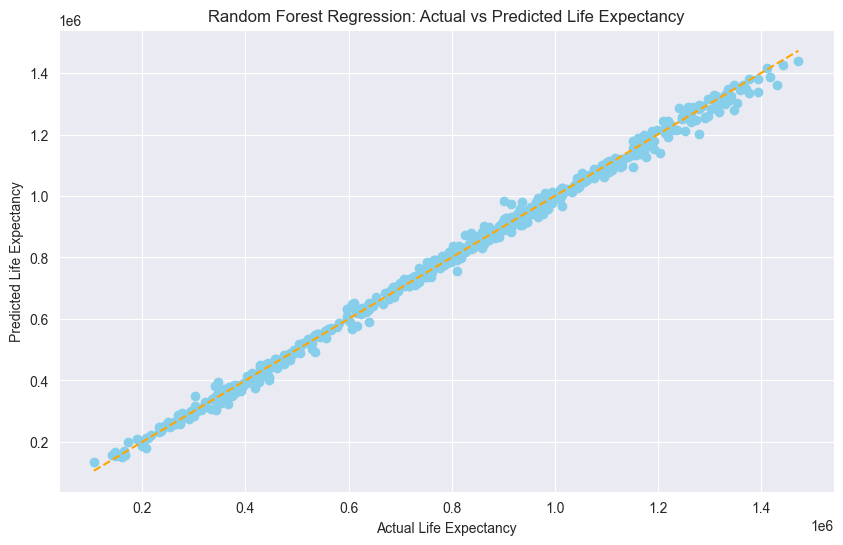

In [166]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_rf, color='skyblue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], linestyle='--', color='orange')
plt.xlabel("Actual Life Expectancy")
plt.ylabel("Predicted Life Expectancy")
plt.title("Random Forest Regression: Actual vs Predicted Life Expectancy")
plt.show()

## Train and evaluate Linear Regression

In [167]:
# Initialize and train the Linear Regression model
linear_model = LinearRegression()
linear_model.fit(X_train_scaled, y_train)  # Using scaled training data

# Make predictions on the test set
y_pred_lr = linear_model.predict(X_test_scaled)

# Check and adjust predictions to ensure all are positive before inverse transformation
y_pred_lr_adjusted = np.where(y_pred_lr <= 0, 1e-6, y_pred_lr)

# Inverse transform predictions and actual values
y_pred_lr_original = inv_boxcox(y_pred_lr_adjusted, lambda_val)
y_test_original = inv_boxcox(y_test, lambda_val)  # Assumes y_test is already positive and transformed

# Calculate error metrics on the original scale
mae_lr_original = mean_absolute_error(y_test_original, y_pred_lr_original)
mse_lr_original = mean_squared_error(y_test_original, y_pred_lr_original)
r2_lr_original = r2_score(y_test_original, y_pred_lr_original)

# Print the recalculated evaluation metrics
print("Linear Regression Results on Original Scale:")
print(f"Mean Absolute Error (MAE): {mae_lr_original:.4f}")
print(f"Mean Squared Error (MSE): {mse_lr_original:.4f}")
print(f"R² Score: {r2_lr_original:.4f}")

Linear Regression Results on Original Scale:
Mean Absolute Error (MAE): 1.9004
Mean Squared Error (MSE): 17.6860
R² Score: 0.7869


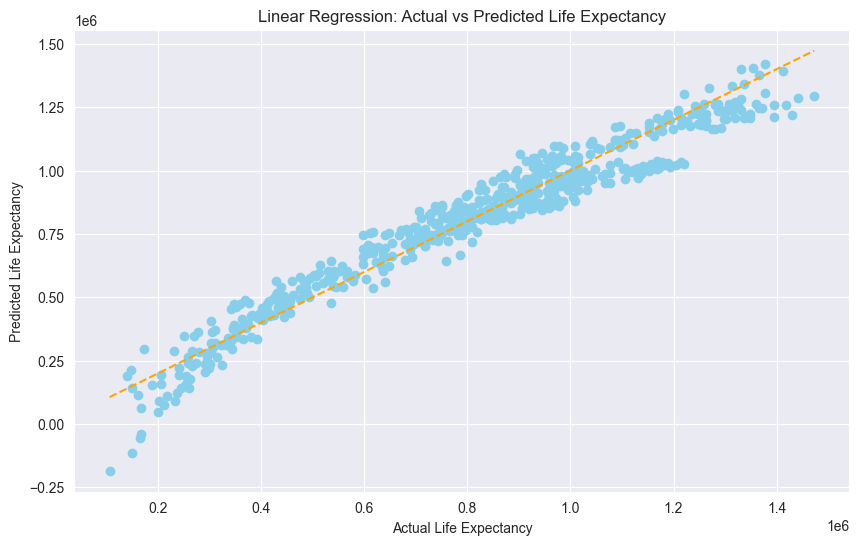

In [168]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_lr, color='skyblue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], linestyle='--', color='orange')
plt.xlabel("Actual Life Expectancy")
plt.ylabel("Predicted Life Expectancy")
plt.title("Linear Regression: Actual vs Predicted Life Expectancy")
plt.show()

# Train and evaluate K-Nearest Neighbors Regressor
## Find the best number of neighbors for KNN

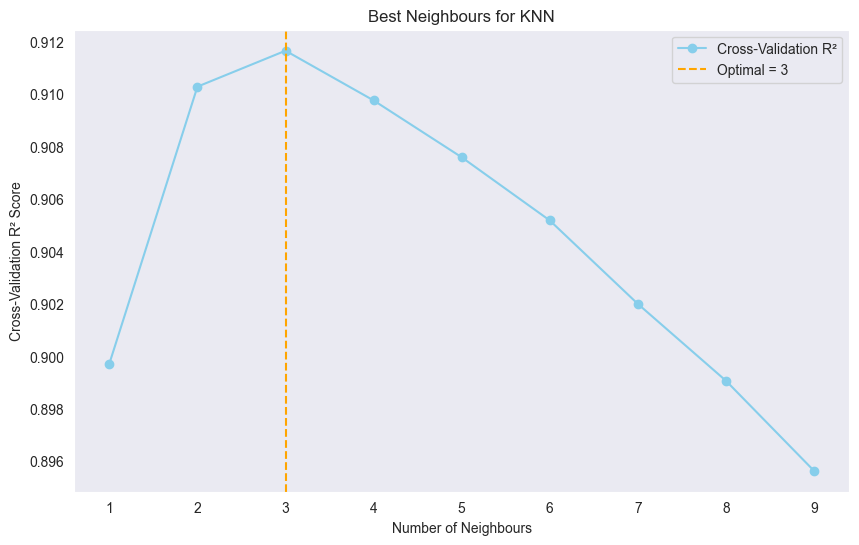

In [169]:
# Initialize the figure
fig, (ax1) = plt.subplots(1, figsize=(10, 6))

# First: Evaluate and plot for transformed data
neighbor_range = range(1, 10)
cv_scores_transformed = []

for n in neighbor_range:
    knn = KNeighborsRegressor(n_neighbors=n)
    scores = cross_val_score(knn, X_train, y_train, cv=5, scoring='r2')
    cv_scores_transformed.append(scores.mean())

best_n_neighbors_transformed = neighbor_range[np.argmax(cv_scores_transformed)]

# Plot for transformed data
ax1.plot(neighbor_range, cv_scores_transformed, marker='o', linestyle='-', color='skyblue', label="Cross-Validation R²")
ax1.axvline(best_n_neighbors_transformed, color='orange', linestyle='--',
            label=f"Optimal = {best_n_neighbors_transformed}")
ax1.set_title("Best Neighbours for KNN")
ax1.set_xlabel("Number of Neighbours")
ax1.set_ylabel("Cross-Validation R² Score")
ax1.legend()
ax1.grid()

plt.show()

## Train and evaluate K-Nearest Neighbors Regressor with the best number of neighbors


In [170]:
# Initialize and train the K-Nearest Neighbors Regressor
knn_model = KNeighborsRegressor(n_neighbors=3)
knn_model.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred_knn = knn_model.predict(X_test_scaled)

# Check and adjust predictions to ensure all are positive before inverse transformation
y_pred_knn_adjusted = np.where(y_pred_knn <= 0, 1e-6, y_pred_knn)

# Inverse transform predictions and actual values
y_pred_knn_original = inv_boxcox(y_pred_knn_adjusted, lambda_val)
y_test_original = inv_boxcox(y_test, lambda_val)  # Assumes y_test is already positive and transformed

# Calculate error metrics on the original scale
mae_knn_original = mean_absolute_error(y_test_original, y_pred_knn_original)
mse_knn_original = mean_squared_error(y_test_original, y_pred_knn_original)
r2_knn_original = r2_score(y_test_original, y_pred_knn_original)

# Print the recalculated evaluation metrics
print("K-Nearest Neighbors Regression Results on Original Scale:")
print(f"Mean Absolute Error (MAE): {mae_knn_original:.4f}")
print(f"Mean Squared Error (MSE): {mse_knn_original:.4f}")
print(f"R² Score: {r2_knn_original:.4f}")

K-Nearest Neighbors Regression Results on Original Scale:
Mean Absolute Error (MAE): 0.5736
Mean Squared Error (MSE): 0.7654
R² Score: 0.9908


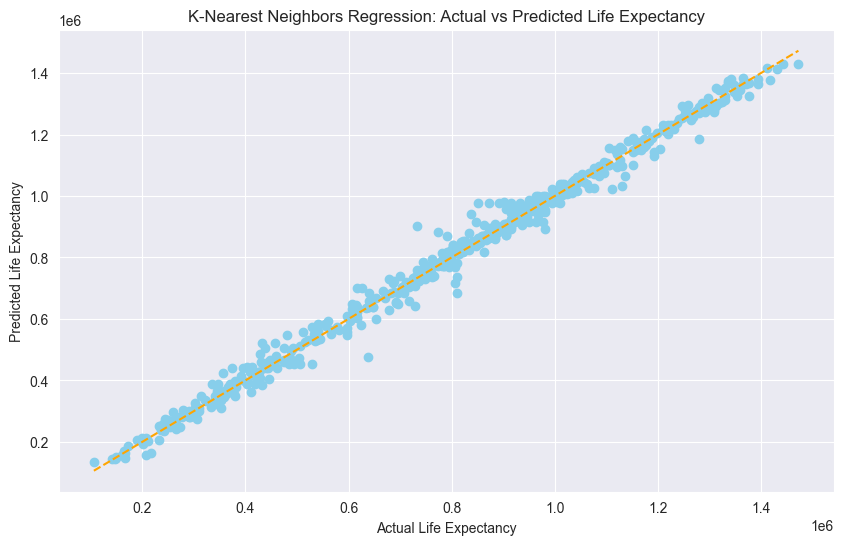

In [171]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_knn, color='skyblue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], linestyle='--', color='orange')
plt.xlabel("Actual Life Expectancy")
plt.ylabel("Predicted Life Expectancy")
plt.title("K-Nearest Neighbors Regression: Actual vs Predicted Life Expectancy")
plt.show()